In [1]:
"""
Overall Backlog Minimization - LP Model:

This linear optimization model tries to minimize the sum of the weighted backlog of all products. 

Input:
Demand Rate 
Production Rate
Yield of line/product
Minimum Lot Size
Initial Inventory Level
Target Inventory Level/Range
Backlog cost/value (weight)
Sequence dependent changeover time between products
Maximum makespan/cycle time allowed.

Objective:
To minimize the overall weighted backlog
To ending inventory is in the target inventory range for all products

Decision Variables:
    Major decision variables:
y[i,j,k,0] -> Binary variable. 1 if there is a changeover from product i to j in the same loop, 0 o/w
y[i,j,k,1] -> Binary variable. 1 if there is a changeover from product i to j in the subsequent loop, 0 o/w
x[i,k] -> Production time of product i in loop k
    
    Supporting decision variables:
z[i,k] -> Binary variable. 1 if product i is produced in loop k, 0 o/w
W[k] -> Binary variable. 1 if loop k is used


Output:
Final Inventory level of all products {I_last}
Actual makespan or cycle time (t)
Production Schedule (x[i,k], y[i,j,k,1 or 0])

Observations:
1. This model takes the first ever setup time into account as well which gives a more accurate result. 
This is acheived by adding a dummy product at the beginning of the operation. 
The features of the dummy product are listed below,
    1. demand rate = 0
    2. production rate = 0
    3. Min lot size = 0
    4. backlog cost or product value = 0
    5. Changeover time from any product to product zero = infinity and changeover from zero to any other product is zero.
       Changeover time from product zero to zero = 0


2. Yield rate has not been implemented. It can be used for setting m/c utiliation as well. 

3. Max lot size has not been implemented. We observed that max lot size is usually in the millions, hence, we thought we 
assumed it is not required. 

There is already a constraint in place to check for maximum lot size, however, we are not using it to reduce the number 
of constraints (a feeble effort to reduce time complexity)

Similarly we have a constraint for two (yield rate) as well. However, we have not implemented in this model as it is not an 
important aspect of testing the model. 

"""

'\nOverall Backlog Minimization - LP Model:\n\nThis linear optimization model tries to minimize the sum of the weighted backlog of all products. \n\nInput:\nDemand Rate \nProduction Rate\nYield of line/product\nMinimum Lot Size\nInitial Inventory Level\nTarget Inventory Level/Range\nBacklog cost/value (weight)\nSequence dependent changeover time between products\nMaximum makespan/cycle time allowed.\n\nObjective:\nTo minimize the overall weighted backlog\nTo ending inventory is in the target inventory range for all products\n\nDecision Variables:\n    Major decision variables:\ny[i,j,k,0] -> Binary variable. 1 if there is a changeover from product i to j in the same loop, 0 o/w\ny[i,j,k,1] -> Binary variable. 1 if there is a changeover from product i to j in the subsequent loop, 0 o/w\nx[i,k] -> Production time of product i in loop k\n    \n    Supporting decision variables:\nz[i,k] -> Binary variable. 1 if product i is produced in loop k, 0 o/w\nW[k] -> Binary variable. 1 if loop k is

In [2]:
#There may be instances where you would have to set target inventory to even negative to allow for backlog at the end of the season. 
# we did discuss removing them altogehter .... see how that goes.... h

In [3]:
import numpy as np
from gurobipy import *
import pandas as pd
import time

In [4]:
m = Model("target_inventory")

Academic license - for non-commercial use only


In [5]:
#Instance with dummy Product
demand = [0,5,2]
prod_rate = [0,28,23] #Production rate per hour
I_zero = [0,5,10] #Initial Inventory
Y = [0.75,0.75,0.75] #yield for product i
Min_lot = [0,20,20]
#I_target_low = [500,200] #Target Inventory_lower
I_target_low = [0,500,200]
I_target_upper = [5,2000,500]
bcost = [0,10,2] #backorder cost
C = np.array([[0, 0, 0],[0,10000,5],[0,4,10000]]) # the infinity does not matter until C is incorporated in Obj fn
loops = 2
prods = [1,2,3]
T = 1000
#define time - is added as variable


In [6]:
#range of products and loops
nprod = range(len(prods)) #for products
nloops = range(loops) #for loops
nmloops = range(loops-1) #for subsequent loops -> not used anywhere
LI = [0,1] #loop indicator -> zero for same, and 1 for next loop 

# Variable Declaration

In [7]:
y = m.addVars(nprod,nprod,nloops,LI, vtype = GRB.BINARY, name = "y") #to indicate switch from product i to product j
z = m.addVars(nprod,nloops, vtype = GRB.BINARY, name = "z") #to indicate if m/c has to be setup for product i in loop k
x = m.addVars(nprod,nloops, vtype = GRB.INTEGER, lb = 0, name = "x") #production time of product i in loop k
inv_k = m.addVars(nprod,nloops, vtype = GRB.CONTINUOUS, lb = -10000000, name = "inv_k") #inventory at the beginning of loop k
#rows are products and columns are loops
L = m.addVars(nprod,nloops, vtype = GRB.CONTINUOUS,lb = -100000000, name = "L") # maximum backlog
#T = m.addVar(vtype=GRB.CONTINUOUS, name = "total_time")
W = m.addVars(nloops, vtype = GRB.BINARY, name = "W")#"Continuous_loop_check")
I_last = m.addVars(nprod, vtype = GRB.CONTINUOUS, name = "I_final")
t = m.addVar(vtype =GRB.CONTINUOUS, name = "cycle time")

# Objective Function

In [8]:
#Objective Function: Weighted backlog 1|s_{jk}|\sum_{i \in [n]}b_{i}L_{i} 
m.setObjective(sum(bcost[i]*L[i,k] for i in nprod for k in nloops), GRB.MINIMIZE)  #+T removed 

# Constraints

In [9]:
#Constraints for backlog Li

#backlog should be greater than 0
m.addConstrs(L[i,k] >= 0 for i in nprod for k in nloops) 

#backlog should be greater than the negative of negative inventory so that it forces it be a positive
m.addConstrs(L[i,k] >= -inv_k[i, k] for i in nprod for k in nloops);

In [10]:
#constraint for initial inventory at beginning of first loop
m.addConstrs(inv_k[i,0] == I_zero[i] 
             - demand[i] *sum(x[j,0] for j in nprod  if j < i)
             - demand[i]*sum(C[l,j]*y[l,j,0,0] for j in nprod for l in nprod if l<j if j<=i) for i in nprod);

In [11]:
m.addConstrs(inv_k[i, k+1] == inv_k[i,k] + x[i,k]*(prod_rate[i] - demand[i])
             - demand[i]*(sum(x[j,k] for j in nprod if j >i) + sum(x[j,k+1] for j in nprod if j<i)
                         + (sum(C[l,j]*y[l,j,k,0] for l in nprod if l>=i for j in nprod if j>l)
                          + sum(C[l,j]*y[l,j,k,1] for j in nprod if j<=i for l in nprod if l>=i))
                         + sum(C[l,j]*y[l,j,k+1,0] for j in nprod for l in nprod if i>=j>l))
             for i in nprod for k in range(loops-1));

In [12]:
#constraint for target inventory - lower bound
k_last = loops - 1
m.addConstrs(I_target_low[i] <= inv_k[i,k_last] +  x[i,k_last]*(prod_rate[i] - demand[i])
             - demand[i] * sum(x[j,k_last] for j in nprod if j > i) 
             - demand[i]*sum(C[l,j]*y[l,j,k_last,0] for l in nprod if l>=i for j in nprod if j>l) for i in nprod);

In [13]:
#constraint for target inventory - upper bound
k_last = loops - 1
m.addConstrs(I_target_upper[i] >= inv_k[i,k_last] +  x[i,k_last]*(prod_rate[i] - demand[i])
             - demand[i] * sum(x[j,k_last] for j in nprod if j > i) 
             - demand[i]*sum(C[l,j]*y[l,j,k_last,0] for l in nprod if l>=i for j in nprod if j>l) for i in nprod);

In [14]:
#Final inventory level - the last loop
m.addConstrs(I_last[i] == inv_k[i,k_last] +  x[i,k_last]*(prod_rate[i] - demand[i])
             - demand[i] * sum(x[j,k_last] for j in nprod if j > i) 
             - demand[i]*sum(C[l,j]*y[l,j,k_last,0] for l in nprod if l>=i for j in nprod if j>l) for i in nprod);

In [15]:
#Constraint to ensure that the makespan is less than the desired cycle time T
m.addConstr(T >= sum(x[i,k] for i in nprod for k in nloops) + sum(C[i,j]*y[i,j,k,u] for i in nprod for j in nprod for k in nloops for u in LI));

#Constraint to record the actual makespan or cycle time 
m.addConstr(t == sum(x[i,k] for i in nprod for k in nloops) + sum(C[i,j]*y[i,j,k,u] for i in nprod for j in nprod for k in nloops for u in LI));


In [16]:
#Constraint to record if product i has been produced in loop k through binary variable z
m.addConstrs(z[i,k] >= x[i,k]/T for i in nprod for k in nloops) 

{(0, 0): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 0): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 0): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>}

In [1]:
m.addConstrs(x[i,k] >= z[i,k]*I_target_low[i] for i in nprod for k in nloops)

NameError: name 'm' is not defined

In [17]:
#constraint to set the values of yij for all products where j > i IN THE SAME LOOP

#m.addConstrs(y[i,j,k,0] >= z[i,k] + z[j,k] - 1 - sum(z[u,k] for u in range(i+1,j-1) if j>i) for j in nprod for i in nprod for k in nloops if j>i);

#constraint to set the values of yij for all products where j > i IN THE SAME LOOP
#m.addConstrs(y[i,j,k,0] >= z[i,k] + z[j,k] - 1 - sum(z[u,k] for u in range(i+1,j) if j>i) for j in nprod for i in nprod for k in nloops if j>i);

#Below Changes added on 11/14/19
#Constraint to set the values of y[ijk0] for all products where j > i, in the same loop
m.addConstrs(y[i,j,k,0] >= z[i,k] + z[j,k] - 1 - sum(z[u,k] for u in range(i+1,j) if j>i if j!=i+1) for j in nprod for i in nprod for k in nloops if j>i);

m.addConstrs(y[i,j,k,0] >= z[i,k] + z[j,k] - 1 for j in nprod for i in nprod for k in nloops if j>i if j==i+1);

In [18]:
#constraint to set the values of y[ijk1] for all products where j < i, in subsequent loops
m.addConstrs(y[i,j,k,1] >= z[i,k] + z[j,k+1] - 1 - sum(z[u,k] for u in nprod if u>i) - sum(z[v,k+1] for v in nprod if v<j)
                for j in nprod for i in nprod for k in range(loops-1));

In [19]:
#Constraint to ensure that the changeover between products in subsequent loops
#happen from higher index to lower index only.
m.addConstrs(y[i,j,k,1] == 0 for i in nprod for j in nprod if j>i for k in range(loops-1) );

#Observation: Necessary constraint otherwise y[0,1,0,0] and y[0,1,0,1] are being set to 1, which cannot happen. 

In [20]:
#Sharat -> 5/12/19, Constraint to avoid changeover between the same product between different loops
m.addConstrs(y[i,i,k,0] == 0 for i in nprod for k in nloops );
m.addConstrs(y[i,i,k,1] == 0 for i in nprod for k in range(loops-1) );

In [21]:
#Constraints to ensure changeover from product i to any other product j!=i happens only once in the same loop or between subsequent loop
m.addConstrs(quicksum(y[i,j,k,0] for j in nprod if j>i) <= 1 for i in nprod for k in nloops)
m.addConstrs(quicksum(y[i,j,k,1] for j in nprod if j<i) <= 1 for i in nprod for k in range(loops-1))

#Ensure y[ijku] is 1 or 0 when it is expected to be that value. This is necessary as it does not allow the system to play around the
#values of these variables.
m.addConstrs(y[i,j,k,0] <= (z[i,k] + z[j,k] + 0.9)/2 for i in nprod for j in nprod for k in nloops if j>i)
m.addConstrs(y[i,j,k,1] <= (z[i,k] + z[j,k+1] + 0.9)/2 for i in nprod for j in nprod for k in range(loops-1) if j<i)

#Ensures z is indeed zero when it is expected to be zero.This is necessary as it does not allow the system to play around the
#values of these variables.
m.addConstrs(z[i,k] <= x[i,k]*T for i in nprod for k in nloops)  #Could lead to infeasibility (any product when manufacutred must be for min of few minutes.)

#Observation: The constraint above "z[i,k] <= x[i,k]*T" requires 1>=x[i,k] or x[i,k]=0. O/w it could make the system infeasible. 

{(0, 0): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 0): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 0): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>}

In [22]:
#Constraints to ensure that a loop in between is not skipped

m.addConstr(W[0] == 1); #Ensures loop 0 is definitely used
m.addConstrs(W[k] >= z[i,k] for i in nprod for k in nloops); #Pushed W to be 1 if any product i is produced in loop k
m.addConstrs(W[k] <= sum(z[i,k] for i in nprod) for k in nloops); #Ensures W is indeed zero when we expect it to be zero
m.addConstrs(W[k+1] <= W[k] for k in range(loops-1)); # loop k+1 cannot be used unless k is used

In [23]:
#Constraints to ensure that when a product i is produced, it is produced for at least the given minimum lot size.
m.addConstrs(x[i,k]*prod_rate[i] >= z[i,k]*Min_lot[i] for i in nprod for k in nloops)


{(0, 0): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 0): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 0): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>}

In [24]:
#-----------Dummy Product Constraint-------------------
#Constraints to ensure that the operation starts with dummy product-zero and 
#there is exactly one changeover from it in the entire cycle. 
m.addConstr(quicksum(y[0,j,0,0] for j in nprod if j!=0) == 1)
#m.addConstrs(quicksum(y[0,j,k,1] for j in nprod) == 0 for k in range(loops-1))
#m.addConstrs(quicksum(y[j,0,k,0] for j in nprod) == 0 for k in nloops)  #not required as the changeover is always from lower index to higher index in the same loop
m.addConstrs(y[j,0,k,1] == 0 for j in nprod for k in range(loops-1))


{(0, 0): <gurobi.Constr *Awaiting Model Update*>,
 (1, 0): <gurobi.Constr *Awaiting Model Update*>,
 (2, 0): <gurobi.Constr *Awaiting Model Update*>}

# Solving the model

In [25]:
start_time = time.time() #Optimization begins
m.optimize();             
end_time = time.time() #Optimization ends


Optimize a model with 110 rows, 66 columns and 297 nonzeros
Variable types: 16 continuous, 50 integer (44 binary)
Coefficient statistics:
  Matrix range     [1e-03, 5e+04]
  Objective range  [2e+00, 1e+01]
  Bounds range     [1e+00, 1e+08]
  RHS range        [5e-01, 2e+03]
Presolve removed 93 rows and 53 columns
Presolve time: 0.00s
Presolved: 17 rows, 13 columns, 61 nonzeros
Variable types: 0 continuous, 13 integer (3 binary)
Found heuristic solution: objective 800.0000000
Found heuristic solution: objective 750.0000000
Found heuristic solution: objective 336.0000000

Root relaxation: objective 0.000000e+00, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    6  336.00000    0.00000   100%     -    0s
H    0     0                     200.0000000    0.00000   100%     -    0s
H    0     0                     150.0000000    0.0000

In [26]:
#Code snippet to retrieve solution
sol = []
for v in m.getVars():
    sol.append((v.Varname, v.X))
    #print("%s %f" % (v.Varname, v.X))
print("The optimal obj. value: "+str(m.objVal))    
#m.write("Backlog_minimization.sol");

The optimal obj. value: 16.0


In [27]:
print("Run-time of the model: "+str(end_time-start_time)+" sec")

Run-time of the model: 0.039893388748168945 sec


In [28]:
#Added by Sharat on 10/18/19 to retrieve only the activated changeover binary variable.

solx=[]
solx= m.getAttr('x', x)   
soly=[]
soly= m.getAttr('x', y)   
solz=[]
solz= m.getAttr('x', z)   

Final_soly =[] 
Sequence = []
proctime = []

for k in nloops:
    for i in nprod:
        for j in nprod:
            for L in range(0,2):
                if soly[i,j,k,L] == 1:
                    Final_soly.append([i,j,k,L])
                    

Final_soly
#Sequence
#proctime
#print("time taken = "+str(end_time-start_time))

[[0, 1, 0, 0], [1, 2, 0, 0], [2, 1, 0, 1], [1, 2, 1, 0]]

In [29]:
for k in nloops:
    for i in nprod:
        if solz[i,k] ==1:
            print("z("+str(i)+","+str(k)+")"+" = "+str(solz[i,k]))

z(0,0) = 1.0
z(1,0) = 1.0
z(2,0) = 1.0
z(1,1) = 1.0
z(2,1) = 1.0


In [30]:
for k in nloops:
    for i in nprod:
        if solx[i,k] > 0:
            #print("processing time of product "+str(i)+" in loop "+str(k)+" = "+str(solx[i,k]))
            print("x("+str(i)+","+str(k)+")"+" = "+str(solx[i,k]))
                    
        
                

x(0,0) = 1.0
x(1,0) = 3.0
x(2,0) = 4.0
x(1,1) = 25.0
x(2,1) = 10.0


In [31]:
I_last

{0: <gurobi.Var I_final[0] (value 0.0)>,
 1: <gurobi.Var I_final[1] (value 504.0)>,
 2: <gurobi.Var I_final[2] (value 218.0)>}

In [32]:
t

<gurobi.Var cycle time (value 57.0)>

In [33]:
df = pd.DataFrame(sol)
df.to_csv("Solutions_formulation_new.csv", header = ["Name","Value"], index = False)

In [34]:
inv_val = [[prod, round(x[prod,loop].X,2),round(inv_k[prod,loop].X,2)] for prod in nprod for loop in nloops]
inv_val = np.array(inv_val)

In [35]:
inv_val

array([[ 0.,  1.,  0.],
       [ 0.,  0.,  0.],
       [ 1.,  3.,  0.],
       [ 1., 25.,  4.],
       [ 2.,  4., -8.],
       [ 2., 10.,  8.]])

In [36]:
import matplotlib.pyplot as plt

1.0 0.0
0.0 0.0


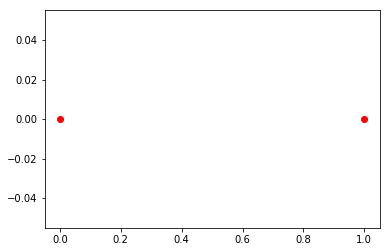

In [37]:
for item in range(len(inv_val)):
    if inv_val[item,0] == 0:
        print(inv_val[item,1], inv_val[item,2])
        plt.plot(inv_val[item,1], inv_val[item,2], 'ro')
plt.show()